In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gp
import os
from shapely.geometry import MultiPoint, Point, Polygon

import haversine as hs
from watertap3.truck_pipe_cost_functions import elevation
from IPython.display import clear_output
import math

Create a csv with centroids based on k means clustering

In [3]:
# Read brackish water previous lcow file with locations
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis_1.csv')
pp_combined_df = pd.read_csv(r'\Users\mhardika\Documents\AMO\MSD Workshop\data\pp_df.csv').drop(['Unnamed: 0'],axis=1)
loc = [Point(xy) for xy in zip(pp_combined_df['PPLongitude'],pp_combined_df['PPLatitude'])]
loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
pp_combined_df['geometry'] = loc


In [4]:
# Function to form clusters

# os.environ["OMP_NUM_THREADS"] = '1'

def form_cluster(df,n_clusters = 3):
    kmeans = KMeans(n_clusters = n_clusters, init ='k-means++')
    kmeans.fit(df[df.columns[1:3]])  # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
    centers = kmeans.cluster_centers_  # Coordinates of cluster centers.
    labels = kmeans.predict(df[df.columns[1:3]])  # Labels of each point
    centers_array = []
    for idx,row in df.iterrows():
        centers_array.append(centers[int(row['cluster_label'])])
    df['centers'] = centers_array
    
    return df

In [5]:
bw_cluster_kmeans = pd.DataFrame()

# Iterate through each state

for state in ['TX']:#bw_df['state_alpha'].unique():
    # print(state)
    # kmeans doesn't work for fewer than 3 points. Calculate centroid for these cases
    if len(bw_df[bw_df['state_alpha'] == state])<=3:
        continue

    bw_state_df = bw_df[bw_df['state_alpha'] == state]

    # First pass at clustering for a state
    bw_state_df_loc = bw_state_df[['unique_site_ID','Latitude','Longitude']].copy()
    bw_state_df_loc = form_cluster(bw_state_df_loc)

    # Assign well yield
    bw_state_df_loc['well_yield'] = bw_state_df['well_yield']
    bw_state_df_loc = bw_state_df_loc.sort_values(['cluster_label'])

    print(bw_state_df_loc['cluster_label'].unique())

    # To keep track of clusters and new created clusters if the maximum capacity of a treatment plant is exceeded
    prev_max_cluster_label = 0

    # Dataframe for each state with their respective cluster id
    cluster_state_df = pd.DataFrame()

    for cluster_id in bw_state_df_loc['cluster_label'].unique():
        
        # Check if maximum capacity of treatment plant is exceeded
        well_yield_total = sum(bw_state_df_loc[bw_state_df_loc['cluster_label']==cluster_id]['well_yield'])
        
        print('Checking cluster:',cluster_id)
        print('Total well yield:', well_yield_total)
        print('Previous max:',prev_max_cluster_label)
        
        max_capacity = math.ceil(50*0.043813)
        if well_yield_total > max_capacity: #10: #--> Update the number based on 27.5 MGD Kay Bailey, Carlbad is 50 MGD
            # If exceed increase number of clusters in the original cluster and redo
            # print(cluster_id,well_yield_total)
            # print('Number of clusters to not hit maximum capacity:', round(well_yield_total/5))
            
            cluster_sub_df = bw_state_df_loc[bw_state_df_loc['cluster_label']==cluster_id].copy()
            
            print("Number of clusters required:", math.ceil(well_yield_total/max_capacity))
            temp_df = form_cluster( cluster_sub_df, n_clusters = math.ceil(well_yield_total/max_capacity))
            temp_df = temp_df.sort_values(['cluster_label'])
            if cluster_id == 0:
                temp_df['cluster_label'].update(prev_max_cluster_label + temp_df['cluster_label'])
            else:
                temp_df['cluster_label'].update(prev_max_cluster_label + temp_df['cluster_label'] + 1)
            prev_max_cluster_label = max(temp_df['cluster_label'])
            
            cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
            print('Added another cluster:',len(temp_df['cluster_label'].unique()))
            print('New cluster:',cluster_state_df['cluster_label'].unique())
            
            print('New max:',prev_max_cluster_label)

        else:
            # If maximum capacity is not exceeded add to state data frame
            temp_bw_state_df_loc = bw_state_df_loc[bw_state_df_loc['cluster_label']==cluster_id].copy()
            temp_bw_state_df_loc['cluster_label'] = prev_max_cluster_label + 1

            cluster_state_df = pd.concat([cluster_state_df,temp_bw_state_df_loc],ignore_index=True)
            prev_max_cluster_label = max(cluster_state_df['cluster_label'])

        print(cluster_state_df['cluster_label'].unique())
    
    bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,cluster_state_df])
    

[0 1 2]
Checking cluster: 0
Total well yield: 2.5799125031926113
Previous max: 0
[1]
Checking cluster: 1
Total well yield: 6.334221026895607
Previous max: 1
Number of clusters required: 3
Added another cluster: 3
New cluster: [1 2 3 4]
New max: 4
[1 2 3 4]
Checking cluster: 2
Total well yield: 3.2713004765161644
Previous max: 4
Number of clusters required: 2
Added another cluster: 2
New cluster: [1 2 3 4 5 6]
New max: 6
[1 2 3 4 5 6]


In [6]:
bw_cluster_kmeans.head()

,unique_site_ID,Latitude,Longitude,cluster_label,centers,well_yield
0,USGS-322805102283801,32.468155,-102.477661,1,"[32.849717354166664, -101.76856669583333]",0.022082
1,NURE-OR11791,34.684000,-100.865000,1,"[32.849717354166664, -101.76856669583333]",0.063090
2,NURE-OR11792,34.681000,-100.898000,1,"[32.849717354166664, -101.76856669583333]",0.063090
3,NURE-OR11855,34.543000,-100.439000,1,"[32.849717354166664, -101.76856669583333]",0.016908
4,NURE-OR14091,29.303000,-103.551000,1,"[32.849717354166664, -101.76856669583333]",0.031545


In [17]:
# math.ceil(3.2713004765161644/(50*0.043813))
(50*0.043813)

2.1906499999999998

In [9]:
# # bw_df_tx_lo['well_yield'] = bw_df['well_yield']
# prev_max_cluster_label = 0

# cluster_state_df = pd.DataFrame()

# for cluster_id in bw_df_tx_loc['cluster_label'].unique():
#     well_yield_total = sum(bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id]['well_yield'])
#     if well_yield_total > 10:
#         print(cluster_id,well_yield_total)
#         print('Number of clusters to not hit maximum capacity:', round(well_yield_total/5))
#         cluster_sub_df = bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id].copy()
#         temp_df = form_cluster(cluster_sub_df,n_clusters = round(well_yield_total/5))
#         temp_df['cluster_label'] = prev_max_cluster_label + temp_df['cluster_label']
#         prev_max_cluster_label = max(temp_df['cluster_label'])
        
#         cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
#     else:
#         cluster_state_df = pd.concat([cluster_state_df,bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id]],ignore_index=True)

# cluster_state_df.head()
        

Create dataframe with all BW site data

In [6]:
# centers_log = []
# centers_lat = []

# for idx , row in bw_cluster_kmeans.iterrows():
#     centers_log.append(row['centers'][1])
#     centers_lat.append(row['centers'][0])

bw_df_centroid = bw_df[bw_df['state_alpha']==state].copy()
# bw_df_centroid['centroid_long']=centers_log
# bw_df_centroid['centroid_lat']=centers_lat
# bw_df_centroid['cluster_id']=bw_cluster_kmeans['cluster_label']

cluster_id_col =[]
centers_long = []
centers_lat = []

# Assign centroid location and cluster label to original brackish water table
for well in bw_df_centroid['unique_site_ID']:
    cluster_id_col.append(bw_cluster_kmeans[bw_cluster_kmeans['unique_site_ID']==well]['cluster_label'].values[0])
    centers_long.append(bw_cluster_kmeans[bw_cluster_kmeans['unique_site_ID']==well]['centers'].values[0][1])
    centers_lat.append(bw_cluster_kmeans[bw_cluster_kmeans['unique_site_ID']==well]['centers'].values[0][0])

bw_df_centroid['cluster_label'] = cluster_id_col
bw_df_centroid['centroid_long'] = centers_long
bw_df_centroid['centroid_lat'] = centers_lat

dist= []
centroid_elev = []
well_elev = []

for i in bw_df_centroid.index:
    clear_output(wait=True)
    print(i, i/len(bw_df_centroid.index))
    bw_long = bw_df_centroid.loc[i]['Longitude']
    bw_lat = bw_df_centroid.loc[i]['Latitude']

    bw_loc = (bw_lat,bw_long)

    cent_long = bw_df_centroid.loc[i]['centroid_long']
    cent_lat = bw_df_centroid.loc[i]['centroid_lat']

    cent_loc = (cent_lat,cent_long)
    print(bw_loc)
    dist_km = hs.haversine(cent_loc,bw_loc)

    dist.append(dist_km)
    centroid_elev.append(elevation(cent_lat,cent_long))
    well_elev.append(elevation(bw_lat,bw_long))


# bw_df_centroid.head(5)

4903 84.53448275862068
(44.5027695, -87.9778824)


In [7]:
bw_df_centroid['dist_miles'] = dist
bw_df_centroid['centroid_elev'] = centroid_elev
bw_df_centroid['well_elev'] = well_elev

bw_df_centroid

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,...,elec_int,tds_out,well_field_o&m,well_field_cap_inv,cluster_label,centroid_long,centroid_lat,dist_miles,centroid_elev,well_elev
498,NURE-OR710187,WI,Marinette,45.065000,-87.693000,492.0,0.015142,1.408867,Wisconsin,0.0731,...,2.630859,0.087034,0.020293,0.203146,2,-88.018240,44.070221,113.575267,253.308990,189.556702
4564,USGS-422956087524601,WI,Kenosha,42.498909,-87.879517,1962.0,0.037980,1.112653,Wisconsin,0.0731,...,4.141953,0.070191,0.182302,0.473242,0,-87.986288,43.074277,64.568671,228.538528,216.740952
4604,USGS-424204087540901,WI,Racine,42.701130,-87.902580,1625.0,0.019243,0.578000,Wisconsin,0.0731,...,3.612691,0.054732,0.077223,0.253238,0,-87.986288,43.074277,42.048855,228.538528,220.004639
4618,USGS-424422087482201,WI,Racine,42.739464,-87.806190,2010.0,0.015773,1.300000,Wisconsin,0.0731,...,4.298486,0.085557,0.077686,0.210917,0,-87.986288,43.074277,40.014960,228.538528,198.160965
4635,USGS-424902087490001,WI,Racine,42.817242,-87.816742,1200.0,0.028706,0.508000,Wisconsin,0.0731,...,3.099767,0.047948,0.086224,0.365825,0,-87.986288,43.074277,31.738307,228.538528,199.233383
4656,USGS-425934087564701,WI,Milwaukee,42.992794,-87.946472,1727.0,0.022712,0.826000,Wisconsin,0.0731,...,3.811303,0.064156,0.096568,0.294945,0,-87.986288,43.074277,9.621109,228.538528,195.910492
4658,USGS-430021087580201,WI,Milwaukee,43.005848,-87.967308,1755.0,0.037854,0.671778,Wisconsin,0.0731,...,3.767346,0.053986,0.163189,0.471796,0,-87.986288,43.074277,7.763767,228.538528,196.631989
4660,USGS-430109087595301,WI,Milwaukee,43.019180,-87.998146,1690.0,0.065614,0.862000,Wisconsin,0.0731,...,3.741233,0.057335,0.272317,0.782402,0,-87.986288,43.074277,6.201826,228.538528,222.239578
4661,USGS-430128091100801,WI,Crawford,43.024429,-91.169022,437.0,0.015142,0.507000,Wisconsin,0.0731,...,2.283717,0.051887,0.018325,0.203146,1,-89.949399,43.108047,99.510736,252.263611,188.130447
4662,USGS-430133088030001,WI,Milwaukee,43.025848,-88.050087,1750.0,0.047318,0.647000,Wisconsin,0.0731,...,3.745587,0.051507,0.203288,0.579258,0,-87.986288,43.074277,7.474885,228.538528,225.282883


In [8]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")
us_states = gp.read_file(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files\tl_rd22_us_state\tl_rd22_us_state.shp')

state_code = '55' #'13' '06'
state_geo = us_counties.loc[us_counties['STATEFP']==state_code]
state_border = us_states.loc[us_states['STATEFP']==state_code]

In [33]:
pp_combined_df.head(1)

,PlantCode,Demand_m3/s,PPLatitude,PPLongitude,PlantState,geometry
0,3,57.648886,31.0069,-88.0103,AL,POINT (-88.0103 31.0069)


In [318]:
# path = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish'
# bw_df_centroid = pd.read_csv(path+r'\ca_bw_lcow_kmeans.csv')

In [35]:
bw_cluster_kmeans.head(1)

,unique_site_ID,Latitude,Longitude,cluster_label,centers,well_yield
0,USGS-431051088061701,43.180839,-88.104813,0,"[43.074277189285716, -87.98628752142857]",0.050472


C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_13576\1843586591.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x = bw_cluster_kmeans['Longitude'], y = bw_cluster_kmeans['Latitude'], c = 'lightblue', s=80, cmap=cm,edgecolor ='black',alpha = 0)


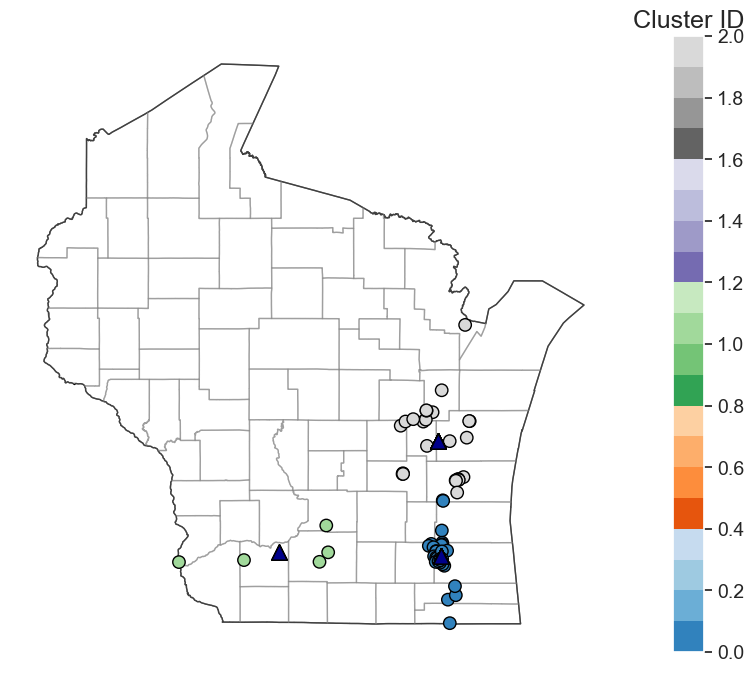

In [9]:
pp_combined_df_state = pp_combined_df[pp_combined_df['PlantState']==state]

centers_log = []
centers_lat = []

for idx , row in bw_cluster_kmeans.iterrows():
    centers_log.append(row['centers'][1])
    centers_lat.append(row['centers'][0])

fig, (ax) = plt.subplots( figsize = (16,8))
ax.axes.set_facecolor(color='white')

cm = plt.cm.get_cmap('tab20c')

state_border.plot(ax=ax,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax,facecolor ='none',edgecolor ='gray',alpha = 0.5)

sc = ax.scatter(x = bw_cluster_kmeans['Longitude'], y = bw_cluster_kmeans['Latitude'], c= bw_cluster_kmeans['cluster_label'].values, s=80, cmap=cm,edgecolor ='black')
ax.scatter(centers_log, centers_lat, c='darkblue', s=120, marker = '^',edgecolor ='black')

ax.scatter(x = bw_cluster_kmeans['Longitude'], y = bw_cluster_kmeans['Latitude'], c = 'lightblue', s=80, cmap=cm,edgecolor ='black',alpha = 0)

# cbaxes = fig.add_axes([0.1, 0.1, 0.03, 0.8]) 
cbar = plt.colorbar(sc,ax=ax,ticks = plt.MaxNLocator(11))
cbar.ax.set_title('Cluster ID',fontsize = 18)
cbar.ax.tick_params(labelsize=14)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_21188\73077854.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(x = bw_cluster_kmeans['Longitude'], y = bw_cluster_kmeans['Latitude'], c = 'lightblue', s=80, cmap=cm,edgecolor ='black',alpha = 0.5 ,label='Brackish Water \nWells')


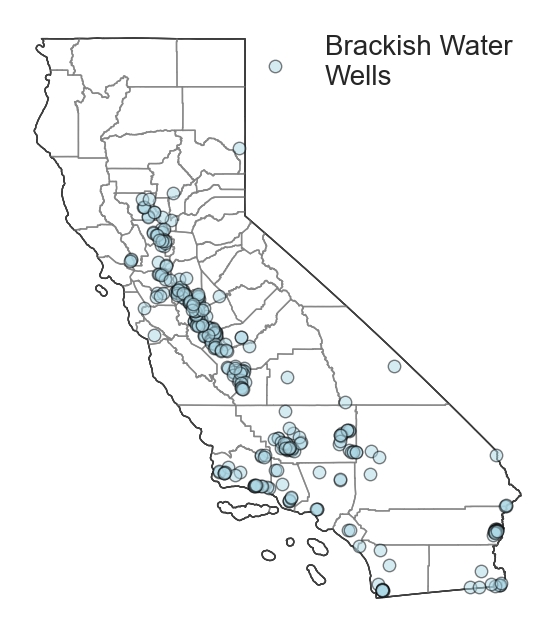

In [13]:
fig, (ax1) = plt.subplots(figsize = (16,8))
# ax1.axis('off')
# ax0.axis('off')
ax1.axes.set_facecolor(color='white')

cm = plt.cm.get_cmap('tab20c')

state_border.plot(ax=ax1,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax1,facecolor ='none',edgecolor ='gray',alpha = 0.5)

state_border.plot(ax=ax1,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax1,facecolor ='none',edgecolor ='gray',alpha = 0.5)

ax1.scatter(x = bw_cluster_kmeans['Longitude'], y = bw_cluster_kmeans['Latitude'], c = 'lightblue', s=80, cmap=cm,edgecolor ='black',alpha = 0.5 ,label='Brackish Water \nWells')
ax1.legend(facecolor = 'white',fontsize=20,frameon=False)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

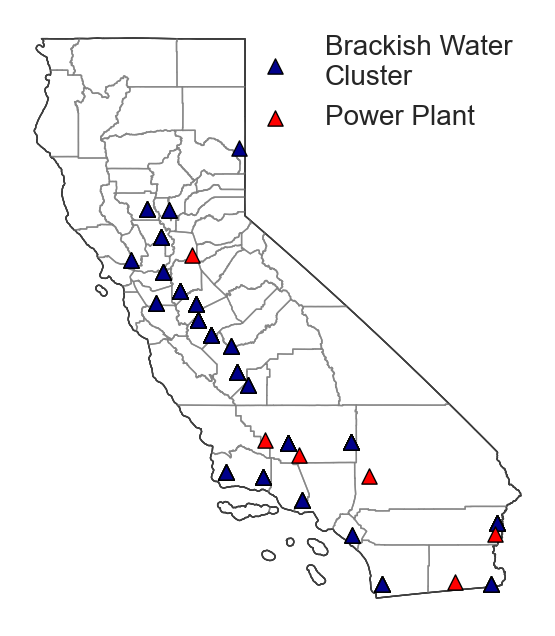

In [14]:
fig, (ax0) = plt.subplots(figsize = (16,8))
ax0.axes.set_facecolor(color='white')
cm = plt.cm.get_cmap('tab20c')

state_border.plot(ax=ax0,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax0,facecolor ='none',edgecolor ='gray',alpha = 0.5)

state_border.plot(ax=ax1,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax1,facecolor ='none',edgecolor ='gray',alpha = 0.5)

state_border.plot(ax=ax0,facecolor ='none',edgecolor ='black')
state_geo.plot(ax=ax0,facecolor ='none',edgecolor ='gray',alpha = 0.5)

ax0.scatter(centers_log, centers_lat, c='darkblue', s=120, marker = '^',edgecolor ='black',label='Brackish Water \nCluster')
ax0.scatter(pp_combined_df_state['PPLongitude'], pp_combined_df_state['PPLatitude'], c='red', s=120, marker = '^',edgecolor ='black', label='Power Plant')

ax0.legend(facecolor = 'white',fontsize=20,frameon=False)

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

In [10]:
path = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish'
bw_df_centroid.to_csv(path+r'\wi_bw_lcow_kmeans_2Nov23.csv')